# LFP amplitude method comparison

## Original
Mazzoni, Lindén et al., 2015, Figure 2B:

<img src="./mazzoni15-fig2b.png" height=400>

In [50]:
import wslfp
import numpy as np
import matplotlib.pyplot as plt

In [51]:
import pandas as pd

df = pd.read_csv("mazzoni15-amp.csv")
df.values.shape

(32, 10)

[Text(0.5, 1.0, 'Mazzoni 2015 amplitude (μV)'),
 Text(0, 0.5, 'Electrode depth (μm)'),
 Text(0.5, 0, 'Electrode lateral distance (μm)')]

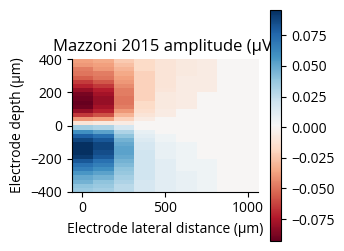

In [52]:
fig, ax = plt.subplots(figsize=(3, 3))
kwargs = dict(cmap="RdBu", extent=[-62.5, 1062.5, -400, 400])

im = ax.imshow(df.values[:, 1:], **kwargs)
fig.colorbar(im)
ax.set(
    title=f"Mazzoni 2015 amplitude (μV)",
    ylabel="Electrode depth (μm)",
    xlabel="Electrode lateral distance (μm)",
)

In [53]:
rng = np.random.default_rng()

d = np.linspace(-600, 600, 50, endpoint=True)
r = np.linspace(0, 1200, 20, endpoint=True)
rr, dd = np.meshgrid(r, d)

# for plotting
rstep = np.diff(r).mean()
dstep = np.diff(d).mean()
extent = [
    rr.min() - rstep / 2,
    rr.max() + rstep / 2,
    dd.min() - dstep / 2,
    dd.max() + dstep / 2,
]

## Aussel et al., 2018 cosine approximation

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'Aussel 2018 amplitude (μV)'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

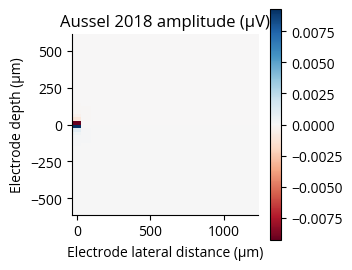

In [54]:
f_aussel = wslfp.aussel18(rr, dd)
wslfp.plot_amp(f_aussel, title="Aussel 2018 amplitude (μV)", extent=extent)

This doesn't match the original figure so well, but is this because this method is actually a principled derivation for a single neuron, as opposed to a measure for a whole population?
To find out, let's average the results over a 250 μm radius cylinder of randomly distributed neurons and see if it matches.

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'Aussel 2018 population amplitude (μV)'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

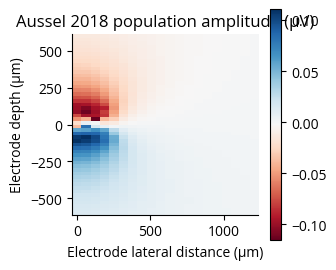

In [55]:
n = 4000
# center of neuron between -100 and 100 microns
nrns_somata = rng.uniform(-250, 0, n)
nrns_apex = rng.uniform(0, 250, n)
dd_neurons = (nrns_somata + nrns_apex) / 2
dd_pop = dd[..., np.newaxis] - dd_neurons
L_pop = nrns_apex - nrns_somata
# horizontal distance: not simple. depends on r
rr_neurons = np.sqrt(rng.uniform(0, 250**2, n))
theta_neurons = rng.uniform(0, 2 * np.pi, n)
rr_pop = np.sqrt(
    (rr[..., np.newaxis] - rr_neurons * np.cos(theta_neurons)) ** 2
    + (rr_neurons * np.sin(theta_neurons)) ** 2
)

f_aussel_pop = wslfp.aussel18(rr_pop, dd_pop, L_pop).sum(axis=2)
wslfp.plot_amp(
    f_aussel_pop, title="Aussel 2018 population amplitude (μV)", extent=extent
)

## Modified Aussel et al., 2018 cosine approximation

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'Modified Aussel 2018 amplitude (μV)'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

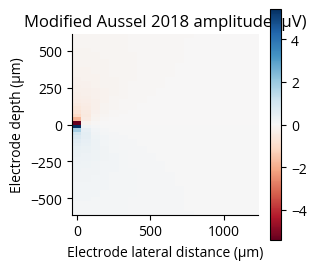

In [56]:
f_aussel_mod = wslfp.aussel18_mod(rr, dd)
wslfp.plot_amp(f_aussel_mod, title="Modified Aussel 2018 amplitude (μV)", extent=extent)

And the population version:

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'Mod. Aussel 2018 population amplitude (μV)'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

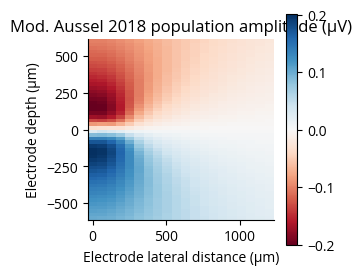

In [57]:
f_aussel_mod_pop = wslfp.aussel18_mod(rr_pop, dd_pop, L_pop).mean(axis=2)
wslfp.plot_amp(
    f_aussel_mod_pop, title="Mod. Aussel 2018 population amplitude (μV)", extent=extent
)

## Interpolated Mazzoni, Lindén et al., 2015 data

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'Mazzoni 2015'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

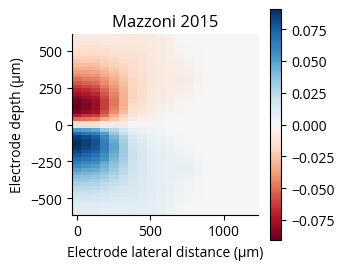

In [58]:
f_ml = wslfp.mazzoni15_pop(rr, dd)
wslfp.plot_amp(f_ml, title="Mazzoni 2015", extent=extent)

## How different are the two?

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': '$f_{aussel}-f_{mazzoni}$'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

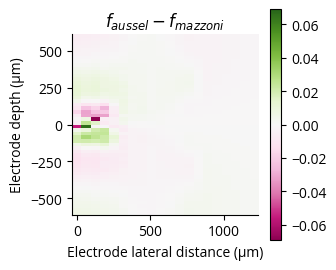

In [63]:
diff = f_aussel_pop - f_ml
wslfp.plot_amp(
    diff,
    title=r"$f_{aussel}-f_{mazzoni}$",
    extent=extent,
    cmap="PiYG",
    vlim=np.max(np.abs(diff)),
)

## What does the Mazzoni profile look like for a population?
That is, if we take it as the profile of a single neuron, what happens after averaging over a population?

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'Mazzoni 2015 population amplitude (μV)'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

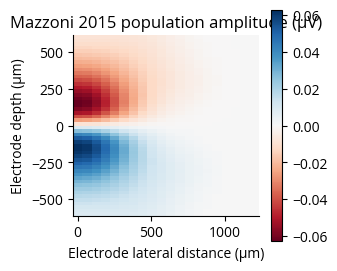

In [66]:
f_mazzoni_pop = wslfp.mazzoni15_pop(rr_pop, dd_pop, L_pop).mean(axis=2)
wslfp.plot_amp(
    f_mazzoni_pop, title="Mazzoni 2015 population amplitude (μV)", extent=extent
)

## Can we shrink the per-neuron Mazzoni-Lindén profile so the population profile matches?

In [73]:
from scipy.optimize import curve_fit


def f_opt(rr_dd_pop, rscale, dscale, fscale):
    rr_pop = rr_dd_pop[0] * rscale
    dd_pop = rr_dd_pop[1] * dscale
    return fscale * wslfp.mazzoni15_pop(rr_pop, dd_pop).mean(axis=2).flatten()


opt_result = curve_fit(f_opt, (rr_pop, dd_pop), f_ml.flatten(), p0=[1, 1, 1])
rscale, dscale, fscale = opt_result[0]
rscale, dscale, fscale

(1.3172372257325766, 1.2243846268512641, 1.828487933608029)

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'LFP amplitude (μV)'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

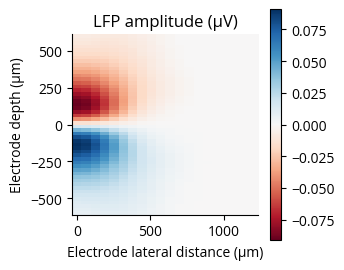

In [74]:
f_ml_shrink_pop = fscale * wslfp.mazzoni15_pop(rr_pop * rscale, dd_pop * dscale).mean(
    axis=2
)
wslfp.plot_amp(f_ml_shrink_pop, extent=extent)

## Summary figure
Here we'll visualize the different profiles directly and see how the `mazzoni15` profile shrunken down for individual neurons is best for capturing the population signal.

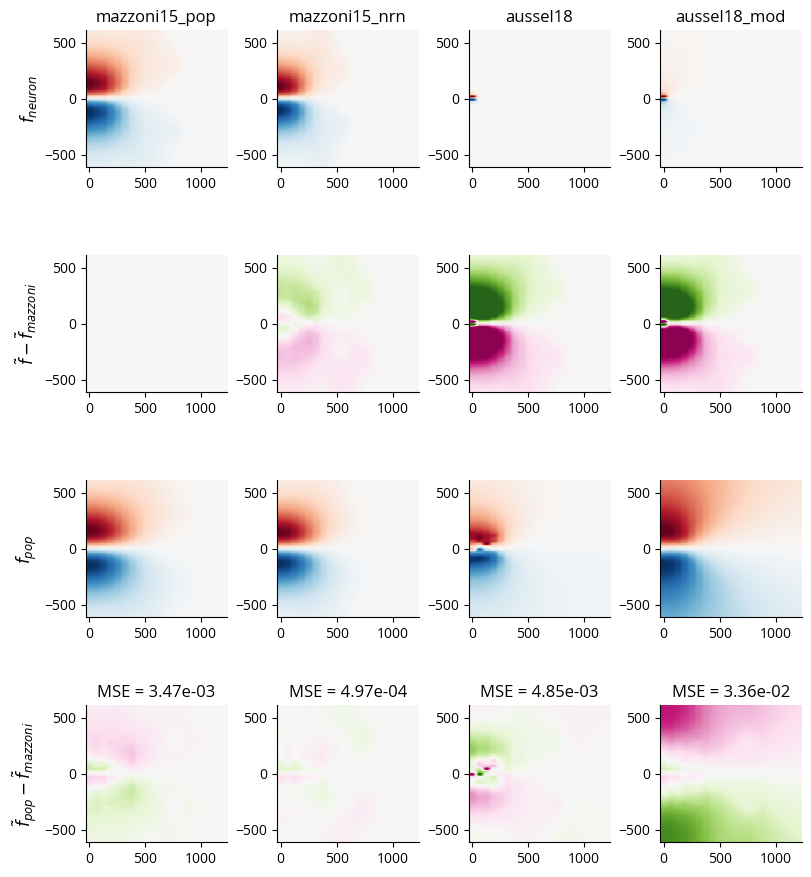

In [77]:
comparison_methods = ["mazzoni15_pop", "mazzoni15_nrn", "aussel18", "aussel18_mod"]
fig, axs = plt.subplots(
    4, len(comparison_methods), figsize=(8, 9), layout="constrained"
)
f_ml_norm = f_ml / f_ml.max()
# need to use same vlim to compare
vlim = 0.5
for method, axcol in zip(comparison_methods, axs.T):
    f = wslfp.f_amp(rr, dd, method=method)
    wslfp.plot_amp(
        f, title=method, extent=extent, cbar=False, labels=False, fig=fig, ax=axcol[0]
    )

    f_norm = f / f.max()
    f_norm = np.nan_to_num(f_norm)
    diff = f_norm - f_ml_norm  # / f_norm * 100
    wslfp.plot_amp(
        diff,
        extent=extent,
        fig=fig,
        cmap="PiYG",
        cbar=False,
        labels=False,
        vlim=vlim,
        ax=axcol[1],
    )

    f_pop = wslfp.f_amp(rr_pop, dd_pop, L_um=L_pop, method=method).mean(axis=2)
    wslfp.plot_amp(
        f_pop,
        extent=extent,
        fig=fig,
        cbar=False,
        labels=False,
        ax=axcol[2],
    )

    f_pop_norm = f_pop / f_pop.max()
    diff_pop = f_pop_norm - f_ml_norm  # / f_norm * 100
    wslfp.plot_amp(
        diff_pop,
        extent=extent,
        fig=fig,
        cmap="PiYG",
        cbar=False,
        vlim=vlim,
        labels=False,
        ax=axcol[3],
        title=f"MSE = {np.mean(diff_pop**2):.2e}",
    )

for ax, row_title in zip(
    axs[:, 0],
    [
        "$f_{neuron}$",
        r"$\tilde{f}-\tilde{f}_{mazzoni}$",
        "$f_{pop}$",
        r"$\tilde{f}_{pop}-\tilde{f}_{mazzoni}$",
    ],
):
    ax.set_ylabel(row_title, rotation=90, size="large")